In [950]:
%load_ext autoreload 
%autoreload 2
import numpy as np
from scipy.optimize import minimize_scalar
from scipy.integrate import cumulative_trapezoid, solve_ivp, solve_bvp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import cmocean


from utility import internal_bore, bore_model, J_boreheight, J_borespeed, J_boremomn

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{lmodern}'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Alongshore Currents Generated by Oblique Internal Bores

From White & Helfrich 2014 (hereafter W&H14) eqn 3.10, the energy flux divergence (equal to the dissipation) of a continuously stratified steady hydrostatic Boussinesq internal bore can be derived from the Bernoulli equation, assuming isopycnals are streamlines.

$$ D = F_x = \int^H_0 C_b(1-\eta_z)\Delta(z)\, dz $$

where $\eta_z$ is the isopycnal displacement, $H$ the water depth, $C_b$ the bore propagation speed, $b(z) = \frac{\rho(z) - \rho(H)}{\rho(0) - \rho(H)} $ the non-dimensional buoyancy, and $\Delta(z)$ is a Bernoulli head loss with an arbitrary vertical structure given by the shape function.

$$\Delta(z) = \Delta_0\big[\frac{1}{2} + \epsilon(b(z) - \frac{1}{2})\big]$$

<!-- Here, we assume $\epsilon = 0$ distributing head loss evenly throughout the water column. -->

W&H14 eqn. 3.2 poses an eigenvalue problem involving the streamline displacement, bore speed, and stratification profile ($\eta$)

$$ \eta_{zz}
+  \frac{N^2(z - \eta)}{C_b^2}\bigg[ \eta 
-  \frac{\Delta_0 \epsilon}{\rho_0 g'} \bigg]
= 0 $$

subject to the boundary conditions $\eta(0) = \eta(H) = 0 $. This can be transformed into a system of first order ODE's; an initial value problem

$$\eta' = \xi$$
$$\xi' = -\frac{N^2(z - \eta)}{C_b^2}\bigg[
\eta -  \frac{\Delta_0 \epsilon}{\rho_0 g'} \bigg]$$

An additional constraint is needed to solve the above which is provided by applying conservation of momentum between the bore and ambient region.

$$ \int^H_0 \big[
\frac{1}{4}\rho_0C_b^2\eta_z^3 - 
(1-\frac{1}{2}\eta_z)\Delta(z)
\big] = 0$$

The above is solved using a nested iterative approach, following White & Helfrich 2014 section 3.6

>The continuous model, (3.4) and (3.7), can be solved by a nested iterative approach
as follows (from the inner- to the outermost levels). (i) Beginning with an initial
value for $\eta_z \equiv \eta'_0$ , a proxy for the bore amplitude, find a value of Cb that satisfies
the eigenvalue problem (3.7) by a shooting method. That is, integrate the ordinary
differential equation (ODE) with initial values $\eta(0) = 0$, $\eta_z(0) = \eta'_0$  iterating on Cb
until the upper boundary condition, $\eta(H) = 0$, is satisfied. (ii) Iterate on $\eta'_0$ until
the bore amplitude, $h_b \equiv \int^H_0 b(z)\,dz$ is equal to the desired value. (iii) Iterate by
varying the head loss constant, $\Delta_0$, until the momentum conservation equation, (3.4),
is satisfied.

## Buoyancy profile

The ambient buoyancy field and its vertical derivative are written as 

$$ b(z) = \frac{1}{2} - \frac{1}{2}\tanh{[\frac{\lambda(z - H_0z_0)}{H_0}]}$$
$$ b'(z) = \frac{\lambda}{2} \text{sech}^2{[\frac{\lambda(z - H_0z_0)}{H_0}]}$$

where $z_0$ is the location of the pycnocline with a thickness $\sim 1/\lambda$ and H_0 is the depth scale for the start of the stratification profile. $\rho(0)$, $\rho(H)$ ,$z_0$, and $\lambda$ were tuned to resemble stratification profiles in McSweeney et al. 2020 JPO Figure 7.

![image](https://journals.ametsoc.org/view/journals/phoc/50/1/full-jpo-d-19-0125.1-f7.jpg)
McSweeney et al. 2020 JPO Figure 7 

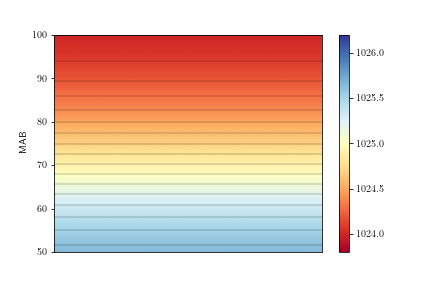

In [951]:
%matplotlib widget
IB = internal_bore(H = 100, H_0 = 100, 𝜆 = 4, z0 = 0.7)

x = np.linspace(0, 10e3, 1000)
h = 0.0*x + 100
s = np.linspace(0,1,100)
Z = np.outer(h,s) 
X = np.outer(x, np.zeros_like(s) + 1)

IB.b, IB.bz = IB.buoyancy(Z)
rho = IB.density()

Zp = Z # - np.outer(h, np.zeros_like(s)+1)

fig, ax = plt.subplots(1)
pc = ax.pcolormesh(X/1e3, Zp, rho, cmap = "RdYlBu", shading = "gouraud", vmin = 1023.8 , vmax = 1026.2)
ax.contour(X/1e3, Zp, rho, np.arange(1024, 1026,0.1), colors = "k", linewidths = 0.25)
plt.colorbar(pc, ax = ax)
ax.set_facecolor("gainsboro")

ax.set_ylabel("MAB")
ax.set_ylim([50,100])
ax.xaxis.set_visible(False)
plt.show()

We find that the parameter choices $H_0 = 100$, $\lambda = 4$, and $z_0 = 0.7$ approximate the observed stratification well

In [1086]:
H = 50
h0 = 100
cb = 0.52
ib = internal_bore(H = H, H_0 = h0, z0 = 0.7, ε = 0) #, d0 = 1e-5,  ε = -1e-2, rho_s = 1024, rho_b = 1024.1, rho_0 = 1024.05)

In [1088]:
#Compute solution: BVP method

# def bc(ya, yb,p):
#     return np.array([ya[0], yb[0], p[0]])

# y0 = np.zeros((2,ib.z.size))
# M = solve_bvp(ib.ode_bvp, bc, ib.z, y0, p = [cb], max_nodes=1e4, verbose = 0)
# M

In [1089]:
#Compute solution: IVP method

dn0 = 1e-1
M = solve_ivp(ib.ode_ivp, [0,ib.H], [0, dn0], args = (cb,), dense_output = True, method = "Radau")
ib.n, ib.nz = M.sol(ib.z)[0], M.sol(ib.z)[1]
ib.z = ib.za + ib.n #displaced isopycnals
ib.b, ib.bz = ib.buoyancy(ib.z + ib.H_0 - ib.H)

display( np.trapz(ib.b, ib.z) )
#display(ib.nz)
#n = ib.streamline_analytic(N = 1e-3, c = .5)

#M

19.33451717913453

In [1090]:
IB = bore_model(h_b = .50*H, ib = ib, cb = cb, disp = True, output = "ib", maxiter = 30)

#J_boremomn(0.01, cb, ib)""
#J_boreheight(dn0 = 1e-7, h_b = 0.5*h0, c = cb, ib = ib)
#J_borespeed(cb, ib, dn0 = 6e-5)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

'dissipation = -5.617...bore amplitude = 19'

In [903]:
#hvals =  h0*np.linspace(0.425,0.575,5)
#dvals = [bore_model(h_b = f, ib = ib, cb = 0.25, disp = False, output = "ib", maxiter = 20).D for f in hvals]

# dnvals = np.linspace(-30, -10, 100)
# hbvals = [J_boreheight(dn0 = d, h_b = 0.4*h0, c = cb, ib = ib) for d in dnvals]

# cbvals = np.linspace(.75, 10, 25)
# n0vals = [J_borespeed(c, ib, dn0 = 6e-5) for c in cbvals]
# n0vals

In [1091]:
ib.bvf()
ib.density();
# ib = IB

In [1092]:
plt.close("all")

In [1094]:
fig, ax = plt.subplots(1,6, figsize = (10,4), sharey = True)
# ax[0].plot(ib.rho, ib.za, "k--")
ax[0].plot(ib.rho, ib.za, "k")
ax[1].plot(ib.N2, ib.z, "b");
ax[2].plot(ib.b, ib.z, "k--")
ax[2].plot(ib.b, ib.za, "k")
ax[3].plot(ib.bz, ib.z, "g")
ax[4].plot(ib.n, ib.z, "m")
ax[4].axvline(color = "k")
ax[5].plot(ib.Δ, ib.z, color  = "orange")


ax[0].set_ylabel("(m)", rotation = 0)

ax[0].set_title("$\\rho$")
ax[2].set_title("$b(z_a)$ - \n $b(z+\eta)$ - -")
ax[1].set_title("$N^2$")
ax[3].set_title("b'(z)")
ax[4].set_title("$\eta$")
ax[5].set_title("$\Delta_0$")

sns.despine()
fig.tight_layout()

In [1095]:
fig, ax = plt.subplots()

h_0 = 100 #reference depth for setting stratification profile
cb = 0.53# speed guess

# hh = np.linspace(100,100,50)
# yy = 0.42*hh
# ax.plot(hh,yy, "k--", label = "$m = 0.42$")

for h in [100]:
    display(f"{h} m...")
    bounds = [0.45*h, 0.55*h] 
    ib = internal_bore(H = h, z0 = 0.7)
    F_hb = minimize_scalar(bore_model, args = (ib,cb), method = "bounded", bounds = bounds, options = dict(maxiter = 50)) #maximize energy loss
    #F_hb = dual_annealing(bore_model, args = (ib,),  bounds = bounds) #maximize energy loss
    #F_hb = brute(bore_model, ranges = [ (20,26) ], args = (ib,) ) #maximize energy loss
    p = ax.scatter(h, F_hb.x, c = -F_hb.fun, s = 75, cmap = "cmo.amp", norm = LogNorm(vmin = 1e-1, vmax = 1e1), 
                   linewidth = 1, edgecolor = "k")
    display(f"F_x = {-F_hb.fun:0.3g}...Hb = {F_hb.x:0.3g}")

cbar = fig.colorbar(p, ax = ax)
cbar.ax.set_ylabel('$F_x$', rotation = 0)
ax.set_xlabel("H")
ax.set_ylabel("$\widetilde{H}a_b$");
sns.despine()

Fascinatingly, it seems that for the given buoyancy profile, $\widetilde{H}_b \approx  0.42 H$ (the dashed line) for all depths. McSweeney et al. 2020 found that the bore amplitudes were roughly one half of the water column across the sampled cross-shore transect, so it is encouraging that this result is consistent with field observations.

## Cross-shore structure of energy flux divergence

Also of interest is the cross-shore structure of the energy flux divergence itself. We plot $F_x$ again, but now against the same  coordinate ($x = 0$ at the 100m isobath and increases shoreward) as in Becherer et al. 2021(a) Figure 7 to invite comparison. A constant slope of $0.01$, characteristic of the region is assumed.

![diss](B21_fig7.jpg)

In [262]:
%matplotlib widget
from matplotlib.colors import TwoSlopeNorm

m = 0.01 #bottom slope
x0 = 100/m #offshore distance of 100m isobath given slope (m) $h = -m*(x-x0) + 100

fig, axes = plt.subplots(2,2,figsize = (6.5,6))

h_s = 90 #shallow isobath
h_d = 100 #deep isobath

#plot Becherer 2021a best fit line
hh = np.linspace(h_s, h_d,1000)
xx = -(hh - 100)/m 
xx *= 1e-3
yy = np.exp(-0.013*xx**2 - 0.18*xx + 5.0)

plt.subplot(2, 1, 1)
plt.plot(xx,yy/1e3, color = "k", label = "B21 polynomial fit")

nd = 4
h = np.linspace(h_s, h_d, nd) #depths
rho = np.zeros((100,nd))
X = np.zeros((100,nd))
Z = np.zeros((100,nd))
N2 = np.zeros((100,nd))

#compute and plot W&H14 solution
for k, f in enumerate(h):
    display(f)
#     bounds = [(0.25)*f, (0.75)*f] 
#     F_hb = minimize_scalar(J_bore, args = (f, h_0, "diss"), method = "bounded", bounds = bounds, 
#                            options = dict(maxiter = 50))

    bounds = [0.55*f, 0.7*f] 
    ib = internal_bore(H = f)
    F_hb = minimize_scalar(bore_model, args = (ib,), method = "bounded", bounds = bounds, options = dict(maxiter = 50, xatol=1e-2)) #maximize energy loss
    IB = bore_model(h_b = F_hb.x, ib = ib, output = "ib", disp = False)
    
    x = -(f - 100)/m
    ps = plt.scatter(x/1e3, IB.D, color = "k", facecolors = "none")

    rho[:,k] = IB.density()
    N2[:,k] = IB.bvf()
    X[:,k] = x
    Z[:,k] = IB.zb - IB.zb.max()
    
ps.set_label("W\&H14")
plt.gca().set_xlabel("x (km)", fontsize = 14)
plt.gca().set_ylabel("$F_x$", rotation = 0, fontsize = 14, labelpad = 15)
plt.gca().set_yscale("log")
plt.gca().legend(frameon = False)

#plot density
pc = axes[1,0].pcolormesh(X/1e3, Z, rho - 1000, cmap = "cmo.dense", shading = "nearest")
axes[1,0].contour(X/1e3, Z, rho - 1000, 20, colors = "w", linewidths = 0.5)
plt.colorbar(pc, ax = axes[1,0], orientation = "horizontal", pad = 0.25)

#compute geostrophic velocity (thermal wind)
f0 = 1e-4
v = cumulative_trapezoid( -(N2/f0)*np.gradient(Z, axis = 1)/np.gradient(X, axis = 1), Z, axis = 0, initial = 0)

#plot geostrophic velocity
pc = axes[1,1].pcolormesh(X/1e3, Z, v, cmap = "cmo.balance", shading = "nearest", norm = TwoSlopeNorm(vcenter = 0))
plt.colorbar(pc, ax = axes[1,1], orientation = "horizontal", pad = 0.25)

for ax in axes.flatten():
    #ax.set_xlim(0,13.5)
    ax.set_xlabel("x (km)", fontsize = 14)

# axes[1,0].set_xlim(0, 13.5)
axes[1,0].set_ylabel("z (m)", rotation = 0, fontsize = 14, labelpad = 20)
axes[1,0].set_facecolor("gainsboro")

axes[1,1].set_facecolor("gainsboro")
axes[1,1].yaxis.set_visible(False)

axes[0,1].set_visible(False)
fig.tight_layout()
sns.despine()

a) The W&H14 solution is plotted against the Becherer 2021a best fit of $F_x$ to observations indicating very strong agreement. The advantage of the W&H14 approach is that it is physics-based rather than statistical. b) The resulting density field due to the theoretical isopycnal displacement by the bore is shown. Density surfaces slope upward towards the shore, creating a cross-shore density gradient. c) The theoretical alongshore geostrophic flow induced by the tilted isopycnals, calculated using thermal wind cast in 

In [67]:
%matplotlib widget
import seaborn as sns

b = IB.b
n = IB.n
zb = IB.zb

fig, ax = plt.subplots(1,4, figsize = (10,4), sharey = True)
ax[0].plot(rho, zb, "k")
ax[1].plot(N2, zb, "b");
ax[2].plot(b, za, "k")
ax[2].plot(b, zb, "k--")

ax[3].plot(n, zb, "r")

ax[0].set_ylabel("(m)", rotation = 0)

ax[0].set_title("$\\rho$")
ax[2].set_title("$b(z_a)$ - \n $b(z+\eta)$ --")
ax[1].set_title("$N^2$")
ax[3].set_title("$\eta$")

sns.despine()
fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [77]:
H = 100
Hb = 0.42*H

IB = internal_bore(H = H, Hb = Hb)
za = np.linspace(0, IB.H, 100)
b, bz = IB.buoyancy(za)
IB.nz = za*0
IB.zb = za + 0
IB.zb, IB.b, IB.bz, IB.n, IB.nz, IB.cb, IB.delta, IB.d0, IB.D  = bore_model(IB, za, disp = False)

N2 = IB.bvf()
rho = IB.density()

## Bore Amplitude.

In W&H14, theoretical predictions were compared to numerical model results, so the desired bore amplitude for use in the iterative procedure was prescribed. Here, however, we must come up with a bore amplitude estimate _a priori_. By applying the W&H14 bore model, we find an $\widetilde{H}_b$ for a given depth and buoyancy profile that maximizes the depth-integrated energy loss ($F_x$), and also be physically realistic ($F_x > 0$). This approach is consistent with the W&H14 finding that the best analytical model fit to simulation involved using a head loss function that maximized dissipation ($\epsilon \rightarrow -\infty$).


In [1019]:
ib.U = ib.D/(ib.H*ib.d0) #W&H 2014 3.10 rearranged to solve for U
display(f"D = {ib.D:0.3g}, U = {ib.U:0.3g} m/s")

'D = 4.75e-05, U = 0.16 m/s'

In [1022]:
def speed(D, H = 50, theta = 15, Cb = 0.5, Cd = 2.5e-3, u0 = 0.25, rho0 = 1025):
    v = (np.pi/2)*H*D*np.sin(theta*np.pi/180)/(rho0*Cd*Cb*u0)
    return v

In [1023]:
speed(ib.D, Cb = 0.53, theta = 3.5, u0 = ib.U)

0.001052214820488826

In [382]:
def periodic_func(t,T, λ = 10, phase = 0):
    return 1/np.cosh(λ*np.sin( (np.pi*(t-phase))/T))

$$ f \frac{dv}{dz} = N^2\frac{d z_{rho}}{dx} $$

Subpanel b) shows the energy flux divergence and vertically integrated dissipation rate plotted against across-shore distance

<!-- ## Isopycnal Displacement

We now focus on the case where $H = 100m, H_b = 42m$, characteristic of bores at Point Sal, and examine  -->

$$\tau_w = \frac{\partial S_{xy}}{\partial x}  = 
D\frac{\sin{\theta}}{C_b} $$

$$\tau_b = c_f \frac{2}{\pi}u_0\overline{v}$$


$$\overline{v} = \frac{\pi}{2} \frac{D \sin{\theta}}{\rho_0 C_b c_f u_0} $$

$$ <D> = \int^T_0 \frac{D_0}{2}\big[\sin(\frac{2\pi t}{T}) + 1\big] dt $$  

$$ <D> = \frac{D_0}{T}\int^T_0 \text{ sech}(\sin\frac{\pi t}{T})dt $$  

In [388]:
%matplotlib widget
T = 12.42*3600/2
λ = 10
t = np.linspace(0,T*4,1000)
f = periodic_func(t,T, λ = λ, phase = T/2 )

plt.figure(figsize = (5,1.5))
plt.plot(t/3600,f,"k")
cff = np.trapz(f, t)/T

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

$$ b(z) = \frac{\rho(z) - \rho(H)}{\rho(0) - \rho(H)} $$

$$ b(z) = \frac{1}{2} - \frac{1}{2}\tanh{[\lambda(z-z_0)]}$$

$$ b'(z) = \frac{\lambda }{2}\text{sech}^2{[\lambda(z-z_0)]}$$

$$\rho_a(z) = \frac{1}{2} - \frac{1}{2}\tanh{[\lambda(z-h_a)]}$$

$$z_0(x\rightarrow 0) = \frac{1}{2}(h_a + h_d)$$

$$h_b = \int^H_0 b(z)\,dz$$

$$\frac{d}{dz} = (1-\eta_z)\frac{d}{dz_a}$$

$$z_a = z - \eta$$

## References

- Becherer, J., Moum, J. N., Calantoni, J., Colosi, J. A., Barth, J. A., Lerczak, J. A., McSweeney, J. M., MacKinnon, J. A., & Waterhouse, A. F. (2021). Saturation of the Internal Tide over the Inner Continental Shelf. Part I: Observations, Journal of Physical Oceanography, 51(8), 2553-2563. Retrieved Sep 28, 2021

- Becherer, J., Moum, J. N., Calantoni, J., Colosi, J. A., Barth, J. A., Lerczak, J. A., McSweeney, J. M., MacKinnon, J. A., & Waterhouse, A. F. (2021). Saturation of the Internal Tide over the Inner Continental Shelf. Part II: Parameterization, Journal of Physical Oceanography, 51(8), 2565-2582.

- Longuet-Higgins, M. S. (1970), Longshore currents generated by obliquely incident sea waves: 1, J. Geophys. Res., 75( 33), 6778– 6789 

- McSweeney, J. M., Lerczak, J. A., Barth, J. A., Becherer, J., MacKinnon, J. A., Waterhouse, A. F., Colosi, J. A., MacMahan, J. H., Feddersen, F., Calantoni, J., Simpson, A., Celona, S., Haller, M. C., & Terrill, E. (2020). Alongshore Variability of Shoaling Internal Bores on the Inner Shelf, Journal of Physical Oceanography, 50(10), 2965-2981. 

- Walter, R. K., Woodson, C. B., Arthur, R. S., Fringer, O. B., and Monismith, S. G. (2012), Nearshore internal bores and turbulent mixing in southern Monterey Bay, J. Geophys. Res., 117, C07017

- White, B., & Helfrich, K. (2014). A model for internal bores in continuous stratification. Journal of Fluid Mechanics, 761, 282-304.

